**PROJECT TWEETS SENTIMENT ANALYZE**

In [1]:
from pyspark.sql import SparkSession

# Creating SparkSession
spark = SparkSession.builder \
    .appName("Project Tweets") \
    .getOrCreate()

In [2]:
# CSV file read
file_path = "/ProjectTweets.csv"  
df = spark.read.csv(file_path, header=False, inferSchema=True)

In [3]:
# Get the schema of the DataFrame
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: long (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [4]:
# Count the number of nulls in each column
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+---+---+
|_c0|_c1|_c2|_c3|_c4|_c5|
+---+---+---+---+---+---+
|  0|  0|  0|  0|  0|  0|
+---+---+---+---+---+---+



In [5]:
# Show the DataFrame to verify the changes
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [6]:
# Rename the columns to the desired names
df = df.withColumnRenamed("_c0", "id") \
       .withColumnRenamed("_c1", "number") \
       .withColumnRenamed("_c2", "date") \
       .withColumnRenamed("_c3", "flag") \
       .withColumnRenamed("_c4", "user") \
       .withColumnRenamed("_c5", "text")

df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
| id|    number|                date|    flag|           user|                text|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum as sum_

#Calculate occurrence counts for (date, user) methods
duplicate_counts = df.groupBy("date", "user").agg(count("*").alias("count"))

#Calculate the total number of occurrences of each (date, user) combination
duplicates_with_counts = duplicate_counts.withColumn('total_repeats', (col('count') - 1))

#Calculate the sum of these extra repetitions
total_duplicate_rows = duplicates_with_counts.agg(sum_('total_repeats')).collect()[0][0]

print(f"Total duplicate rows based on 'date' and 'user': {total_duplicate_rows}")


Total duplicate rows based on 'date' and 'user': 2100


In [8]:
#Calculate number of rows before removing duplicate rows
original_count = df.count()

#Remove duplicate records based on `date` and `user` columns
df = df.dropDuplicates(['date', 'user'])

#Calculate number of rows after removing duplicate rows
new_count = df.count()

#Calculate number of deleted rows
deleted_rows = original_count - new_count

print(f"Original row count: {original_count}")
print(f"New row count after removing duplicates: {new_count}")
print(f"Number of rows deleted: {deleted_rows}")

Original row count: 1600000
New row count after removing duplicates: 1597900
Number of rows deleted: 2100


In [9]:
# Remove 'number', 'flag', and 'user' columns from the DataFrame
df = df.drop('number', 'flag', 'user')

# To show the remaining columns in the DataFrame after dropping the specified ones
df.show()

+------+--------------------+--------------------+
|    id|                date|                text|
+------+--------------------+--------------------+
|812254|Fri Apr 17 20:37:...|@Sims_Galore - oh...|
|812269|Fri Apr 17 20:37:...|I gots a beta fis...|
|812532|Fri Apr 17 21:12:...|@journik haha, th...|
|  8929|Fri Apr 17 21:12:...|@parakeetluvr im ...|
|812674|Fri Apr 17 21:17:...|@MCA31 hahaha shh...|
|  9046|Fri Apr 17 21:21:...|my parents wouldn...|
|812688|Fri Apr 17 21:22:...|Hope everyone has...|
|812812|Fri Apr 17 21:27:...|heh time for some...|
|  9121|Fri Apr 17 21:27:...|going to bed, so ...|
|812857|Fri Apr 17 21:27:...|@bbrannan I'm and...|
|  9226|Fri Apr 17 21:35:...|Why do we have to...|
|813150|Fri Apr 17 21:42:...|@NicoleLaurenL do...|
|  9374|Fri Apr 17 21:46:...|Just found out ou...|
|813263|Fri Apr 17 21:52:...|@selenagomez Haha...|
|813296|Fri Apr 17 21:52:...|@plastic_heartss ...|
|813558|Fri Apr 17 22:07:...|just started the ...|
|813722|Fri Apr 17 22:12:...|@R

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import re

# Define UDF
@udf(StringType())
def format_date(date_str):
    # Separate the date and year, discard the time information
    match = re.search(r'\w{3} (\w{3}) (\d{2}) .* (\d{4})', date_str)
    if match:
        month_str = match.group(1)
        day = match.group(2)
        year = match.group(3)
        # A dictionary to convert month name to number
        month_to_num = {"Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
                        "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"}
        month = month_to_num.get(month_str, "Unknown")
        if month != "Unknown":
            return f"{year}-{month}-{day}"
    return None

# Update 'date' column
df = df.withColumn('date', format_date(col('date')))

# Sort DataFrame using 'date' column
df = df.orderBy('date')

# Select only the desired columns
df = df.select('id', 'date', 'text')

# Show results
df.show()

+------+----------+--------------------+
|    id|      date|                text|
+------+----------+--------------------+
|    33|2009-04-06|@julieebaby awe i...|
|   341|2009-04-06|@hyperbets i hope...|
|800203|2009-04-06|pullin an all nig...|
|  1403|2009-04-06|thanks chaffie......|
|    62|2009-04-06|The Life is cool....|
|800500|2009-04-06|Happy Morning, la...|
|800634|2009-04-06|@turtlebus i want...|
|   515|2009-04-06|Death is peaceful...|
|   518|2009-04-06|Such a tough game...|
|   154|2009-04-06|@jonathanchard No...|
|800864|2009-04-06|@arhi cred ca ai ...|
|   662|2009-04-06|@stephenkruiser Y...|
|   668|2009-04-06|i dont want to be...|
|801025|2009-04-06|done with all pre...|
|801505|2009-04-06|@knitster totally...|
|  1200|2009-04-06|The one day I hav...|
|  1266|2009-04-06|@avisionofbeauty ...|
|  1340|2009-04-06|Chewie update. OC...|
|801869|2009-04-06|Only ï¿½18, that'...|
|800692|2009-04-06|http://twitpic.co...|
+------+----------+--------------------+
only showing top

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max

# Calculate Min ve Max date values
date_range = df.select(min("date").alias("min_date"), max("date").alias("max_date")).collect()

min_date = date_range[0]['min_date']
max_date = date_range[0]['max_date']

# Print date range
print(f"The dataset spans from {min_date} to {max_date}.")

The dataset spans from 2009-04-06 to 2009-06-25.


In [12]:
from pyspark.sql import functions as F

# Group the data by date and count the number of tweets for each date
daily_tweet_counts = df.groupBy("date").agg(F.count("*").alias("tweet_count"))

# Sort the results by date for easier viewing
daily_tweet_counts = daily_tweet_counts.orderBy("date")

# Show the results
daily_tweet_counts.show()

+----------+-----------+
|      date|tweet_count|
+----------+-----------+
|2009-04-06|       3354|
|2009-04-07|      17289|
|2009-04-17|       3078|
|2009-04-18|      21729|
|2009-04-19|      27427|
|2009-04-20|      18428|
|2009-04-21|       8552|
|2009-05-01|       7681|
|2009-05-02|      27346|
|2009-05-03|      35281|
|2009-05-04|      15455|
|2009-05-09|      11729|
|2009-05-10|      25980|
|2009-05-11|       4183|
|2009-05-13|       4062|
|2009-05-14|      17430|
|2009-05-16|       9135|
|2009-05-17|      40098|
|2009-05-18|      36412|
|2009-05-21|       2128|
+----------+-----------+
only showing top 20 rows



In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, lit
from pyspark.sql.types import DateType
import pandas as pd

# Convert string dates to datetime objects
min_date = pd.to_datetime(min_date).date()
max_date = pd.to_datetime(max_date).date()

# Generate a list of dates between min_date and max_date
date_list = [min_date + pd.Timedelta(days=x) for x in range((max_date - min_date).days + 1)]

# Convert the list of dates to a list of tuples
date_tuples = [(d,) for d in date_list]

# Create a DataFrame from the list of tuples
date_df = spark.createDataFrame(date_tuples, ['date'])

# Ensure the date column is of type DateType
date_df = date_df.withColumn("date", col("date").cast(DateType()))

# Group the data by date and count the number of tweets for each date
daily_tweet_counts = df.groupBy("date").agg(count("*").alias("tweet_count"))

# Join the date range with the tweet counts
full_data = date_df.join(daily_tweet_counts, "date", "left_outer")

# Replace null values in tweet_count with 0
full_data = full_data.na.fill({"tweet_count": 0})

# Check if there are any days with 0 tweets and sort by date
days_with_zero_tweets = full_data.filter(col('tweet_count') == 0).orderBy("date")

# Show the results - display all rows instead of default top 20
days_with_zero_tweets.show(days_with_zero_tweets.count(), False)

+----------+-----------+
|date      |tweet_count|
+----------+-----------+
|2009-04-08|0          |
|2009-04-09|0          |
|2009-04-10|0          |
|2009-04-11|0          |
|2009-04-12|0          |
|2009-04-13|0          |
|2009-04-14|0          |
|2009-04-15|0          |
|2009-04-16|0          |
|2009-04-22|0          |
|2009-04-23|0          |
|2009-04-24|0          |
|2009-04-25|0          |
|2009-04-26|0          |
|2009-04-27|0          |
|2009-04-28|0          |
|2009-04-29|0          |
|2009-04-30|0          |
|2009-05-05|0          |
|2009-05-06|0          |
|2009-05-07|0          |
|2009-05-08|0          |
|2009-05-12|0          |
|2009-05-15|0          |
|2009-05-19|0          |
|2009-05-20|0          |
|2009-05-24|0          |
|2009-06-08|0          |
|2009-06-09|0          |
|2009-06-10|0          |
|2009-06-11|0          |
|2009-06-12|0          |
|2009-06-13|0          |
+----------+-----------+



**DATA CLEANING**

In [14]:
from pyspark.sql.functions import col, lower

# Convert all text to lowercase to ensure uniformity
df = df.withColumn('text', lower(col('text')))

In [15]:
from pyspark.sql.functions import regexp_replace

# Remove URLs from the text column
df = df.withColumn('text', regexp_replace(col('text'), r'http\S+', ''))

In [16]:
# Remove user mentions that start with @
df = df.withColumn('text', regexp_replace(col('text'), r'@\w+', ''))

In [17]:
from pyspark.sql.functions import translate
import string

# Remove punctuation marks from the text column
df = df.withColumn('text', translate(col('text'), string.punctuation, ''))

In [18]:
# Remove digits from the text column
df = df.withColumn('text', regexp_replace(col('text'), r'\d+', ''))

In [19]:
# Convert smiley faces to word equivalents
df = df.withColumn('text', regexp_replace(col('text'), ':\)', ' smile '))
df = df.withColumn('text', regexp_replace(col('text'), ':\(', ' sad '))

**SENTIMENT ANALYSIS**

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType, FloatType
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import word_tokenize

# Download necessary NLTK data
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')


# Define a function for sentiment analysis that filters sentiment words
def filter_sentiment_words(text):
    # Create SentimentIntensityAnalyzer object
    sia = SentimentIntensityAnalyzer()
    # Tokenize the text into words
    words = word_tokenize(text)
    # Select words that express sentiment
    filtered_words = [word for word in words if sia.polarity_scores(word)['compound'] != 0]
    return filtered_words

# Define a UDF for Spark
filter_sentiment_udf = udf(filter_sentiment_words, ArrayType(StringType()))

# Define a UDF to get the sentiment score
sentiment_score_udf = udf(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'], FloatType())

# Apply the UDFs to the 'text' column
df = df.withColumn("sentiment_words", filter_sentiment_udf(col("text")))
df = df.withColumn("sentiment_score", sentiment_score_udf(col("text")))

# Select the necessary columns and rename the 'sentiment_words' column to 'text'
df = df.select("id", "date", col("sentiment_words").alias("text"), "sentiment_score")

# Show the result
df.show(truncate=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


+------+----------+----------------------------+---------------+
|id    |date      |text                        |sentiment_score|
+------+----------+----------------------------+---------------+
|800013|2009-04-06|[feeling, lost]             |-0.2023        |
|124   |2009-04-06|[hate, sick]                |-0.7906        |
|800126|2009-04-06|[great, love]               |0.8519         |
|800171|2009-04-06|[]                          |0.0            |
|153   |2009-04-06|[sure, fun]                 |-0.5667        |
|195   |2009-04-06|[shit, screwed]             |-0.2942        |
|800385|2009-04-06|[please, lol]               |0.6249         |
|329   |2009-04-06|[ha]                        |0.34           |
|800662|2009-04-06|[liking, ftw]               |0.6922         |
|509   |2009-04-06|[vain, fav]                 |0.4767         |
|800689|2009-04-06|[haha]                      |0.4588         |
|800736|2009-04-06|[]                          |0.0            |
|656   |2009-04-06|[wish,

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

# Group by 'date' column and calculate average for 'sentiment_score'
avg_scores = df.groupBy("date").agg(avg("sentiment_score").alias("avg_score"))

# Sort results by 'date' column
avg_scores = avg_scores.orderBy("date")

# Convert Spark DataFrame to Pandas DataFrame
avg_scores_pd = avg_scores.toPandas()

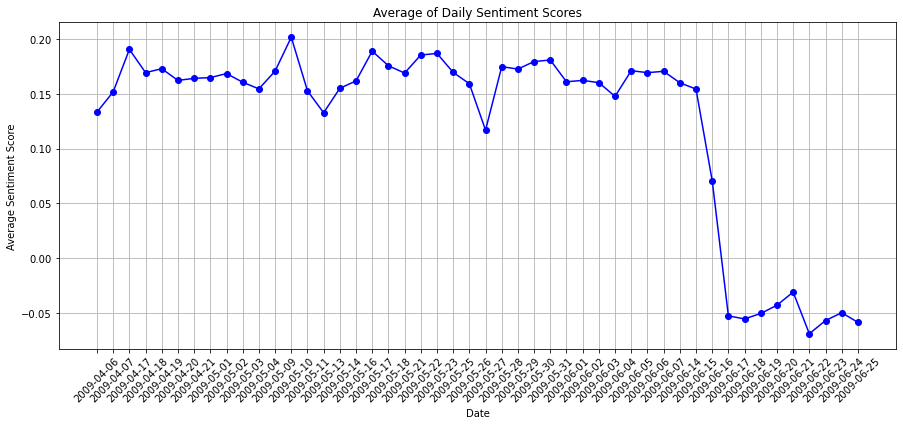

In [22]:
# Create chart
plt.figure(figsize=(15, 6))
plt.plot(avg_scores_pd['date'], avg_scores_pd['avg_score'], marker='o', linestyle='-', color='b')

# Chart title and axis names
plt.title('Average of Daily Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')

# Show
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**FILLING MISSING PARTS IN TIME SERIES**

In [23]:
# Sort results by 'date' column
sorted_avg_scores = avg_scores.orderBy("date")

# Show ranked results
sorted_avg_scores.show()

+----------+-------------------+
|      date|          avg_score|
+----------+-------------------+
|2009-04-06|0.13340169927869608|
|2009-04-07|0.15183019220398916|
|2009-04-17|0.19066715369263437|
|2009-04-18|0.16942562412902532|
|2009-04-19| 0.1730034340214993|
|2009-04-20|0.16230840523925816|
|2009-04-21| 0.1641959300644182|
|2009-05-01| 0.1648642876779724|
|2009-05-02|0.16855466190091184|
|2009-05-03|0.16065679485910103|
|2009-05-04| 0.1545674856315873|
|2009-05-09|0.17081226845243022|
|2009-05-10|0.20178964194375484|
|2009-05-11| 0.1527922297874794|
|2009-05-13|0.13275977309070094|
|2009-05-14| 0.1550964253116172|
|2009-05-16| 0.1618430755750891|
|2009-05-17|0.18903327036985862|
|2009-05-18|0.17569216687780212|
|2009-05-21| 0.1690387681671033|
+----------+-------------------+
only showing top 20 rows



In [24]:
from pyspark.sql.functions import to_date, lit, avg

# Filter data up to 14-06-2009
filtered_data = sorted_avg_scores.filter(sorted_avg_scores["date"] <= lit("2009-06-14"))

# Calculate the average 'sentiment score' of the filtered data
average_score = filtered_data.agg(avg("avg_score")).collect()[0][0]

# Print average score
print("Average sentiment score of data until 14-06-2009:", average_score)

Average sentiment score of data until 14-06-2009: 0.16571399216437327


In [25]:
from pyspark.sql import Row
from pyspark.sql.functions import lit, to_date

# List of missing dates
missing_dates = [
    "2009-04-08", "2009-04-09", "2009-04-10", "2009-04-11", "2009-04-12",
    "2009-04-13", "2009-04-14", "2009-04-15", "2009-04-16", "2009-04-22",
    "2009-04-23", "2009-04-24", "2009-04-25", "2009-04-26", "2009-04-27",
    "2009-04-28", "2009-04-29", "2009-04-30", "2009-05-05", "2009-05-06",
    "2009-05-07", "2009-05-08", "2009-05-12", "2009-05-15", "2009-05-19",
    "2009-05-20", "2009-05-24", "2009-06-08", "2009-06-09", "2009-06-10",
    "2009-06-11", "2009-06-12", "2009-06-13"
]

# Create DataFrame for missing dates
missing_dates_df = spark.createDataFrame([Row(date=d) for d in missing_dates])

# Assign the calculated average value to each missing date
filled_df = missing_dates_df.withColumn("avg_score", lit(average_score))

# Show results
filled_df.show()

+----------+-------------------+
|      date|          avg_score|
+----------+-------------------+
|2009-04-08|0.16571399216437327|
|2009-04-09|0.16571399216437327|
|2009-04-10|0.16571399216437327|
|2009-04-11|0.16571399216437327|
|2009-04-12|0.16571399216437327|
|2009-04-13|0.16571399216437327|
|2009-04-14|0.16571399216437327|
|2009-04-15|0.16571399216437327|
|2009-04-16|0.16571399216437327|
|2009-04-22|0.16571399216437327|
|2009-04-23|0.16571399216437327|
|2009-04-24|0.16571399216437327|
|2009-04-25|0.16571399216437327|
|2009-04-26|0.16571399216437327|
|2009-04-27|0.16571399216437327|
|2009-04-28|0.16571399216437327|
|2009-04-29|0.16571399216437327|
|2009-04-30|0.16571399216437327|
|2009-05-05|0.16571399216437327|
|2009-05-06|0.16571399216437327|
+----------+-------------------+
only showing top 20 rows



In [26]:
# Merge 'sorted_avg_scores' and 'filled_df' DataFrames
combined_df = sorted_avg_scores.union(filled_df)

# Sort merged DataFrame by 'date' column
combined_sorted_df = combined_df.orderBy("date")

# Show results
combined_sorted_df.show()

+----------+-------------------+
|      date|          avg_score|
+----------+-------------------+
|2009-04-06|0.13340169927869608|
|2009-04-07|0.15183019220398916|
|2009-04-08|0.16571399216437327|
|2009-04-09|0.16571399216437327|
|2009-04-10|0.16571399216437327|
|2009-04-11|0.16571399216437327|
|2009-04-12|0.16571399216437327|
|2009-04-13|0.16571399216437327|
|2009-04-14|0.16571399216437327|
|2009-04-15|0.16571399216437327|
|2009-04-16|0.16571399216437327|
|2009-04-17|0.19066715369263437|
|2009-04-18|0.16942562412902532|
|2009-04-19| 0.1730034340214993|
|2009-04-20|0.16230840523925816|
|2009-04-21| 0.1641959300644182|
|2009-04-22|0.16571399216437327|
|2009-04-23|0.16571399216437327|
|2009-04-24|0.16571399216437327|
|2009-04-25|0.16571399216437327|
+----------+-------------------+
only showing top 20 rows



In [27]:
# Convert Spark DataFrame to Pandas DataFrame
combined_sorted_pd = combined_sorted_df.toPandas()

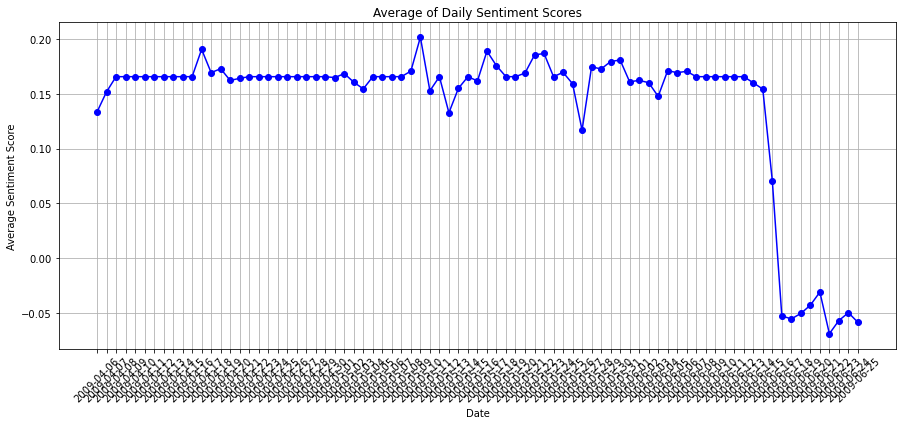

In [28]:
# Create chart
plt.figure(figsize=(15, 6))
plt.plot(combined_sorted_pd['date'], combined_sorted_pd['avg_score'], marker='o', linestyle='-', color='b')

# Chart title and axis names
plt.title('Average of Daily Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')

# Show
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**TIME SERIES FORECASTING**

In [29]:
# To convert PySpark DataFrame to Pandas DataFrame
pandas_df = combined_sorted_df.toPandas()

# To perform ADF testing using the statsmodels library
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on 'sentiment_score' column
result = adfuller(pandas_df['avg_score'].values, autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret ADF test result
if result[1] > 0.05:
    print("Time series are not stationary.")
else:
    print("Time series are stationary.")

ADF Statistic: 0.027113
p-value: 0.960718
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586
Time series are not stationary.


In [30]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARIMA model (set the parameters p, d, q)
# Here we use default parameters (1,1,1) for demonstration.
# Due to non-stationary time series, we used ARIMA because ARIMA already doing stationary steps(d=1)
model = ARIMA(combined_sorted_pd['avg_score'], order=(1,1,1))
model_fit = model.fit()

# Forecast for the next 7 days (1 week)
forecast = model_fit.get_forecast(steps=7)
predicted_mean = forecast.predicted_mean

# Get the forecasted values and the confidence intervals
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


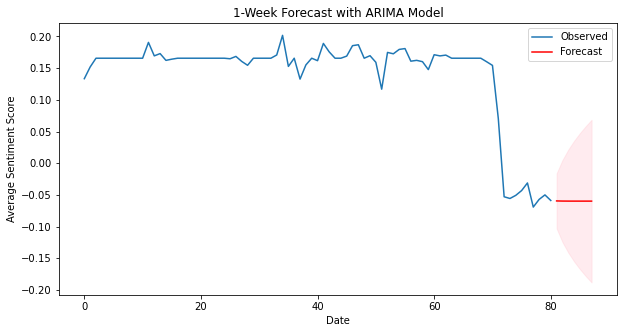

In [31]:
# Plot the observed data and the forecast with confidence intervals
plt.figure(figsize=(10,5))
plt.plot(combined_sorted_pd['avg_score'], label='Observed')
plt.plot(predicted_mean.index, predicted_mean, color='red', label='Forecast')
plt.fill_between(predicted_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('1-Week Forecast with ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


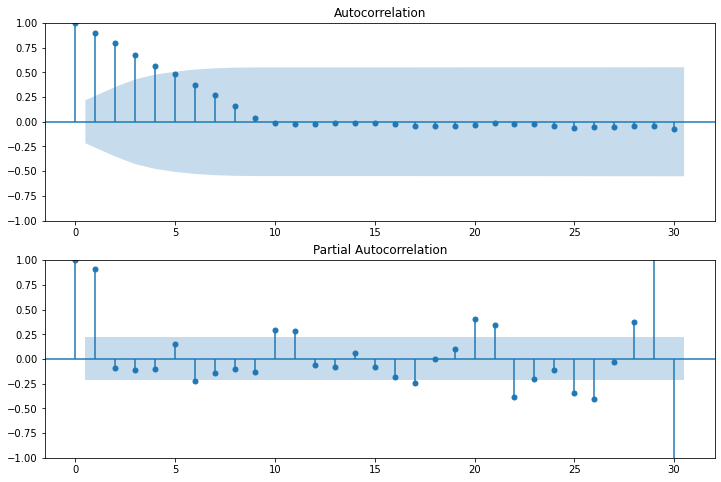

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#Due to ARIMA model failed, we started to find p,d,q parameters for make our time series stationary
# PLot ACF and PACF graphs
plt.figure(figsize=(12,8))

plt.subplot(211)
plot_acf(combined_sorted_pd['avg_score'], ax=plt.gca(), lags=30)

plt.subplot(212)
plot_pacf(combined_sorted_pd['avg_score'], ax=plt.gca(), lags=30)

plt.show()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipykernel_28955/99056737.py:12: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_index =

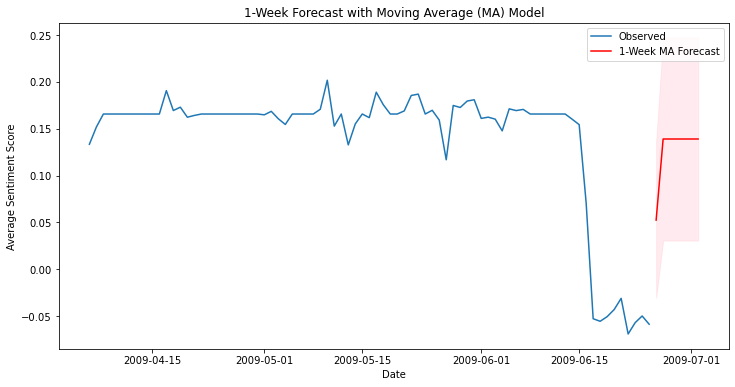

In [39]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Fit a Moving Average model (assuming MA(1) based on the initial ACF plot)
# Since the data is stationary, we do not need to difference (d=0)
model = ARIMA(combined_sorted_pd['avg_score'], order=(0, 0, 1))  # MA(1) model
model_fit = model.fit()

# Forecast for the next 7 days
forecast = model_fit.get_forecast(steps=7)
forecast_index = pd.date_range(start=combined_sorted_pd.index[-1], periods=8, closed='right')
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the observed data and the forecast with confidence intervals
plt.figure(figsize=(12,6))
plt.plot(combined_sorted_pd.index, combined_sorted_pd['avg_score'], label='Observed')
plt.plot(forecast_index, predicted_mean, color='red', label='1-Week MA Forecast')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('1-Week Forecast with Moving Average (MA) Model')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipykernel_28955/525436953.py:11: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_index 

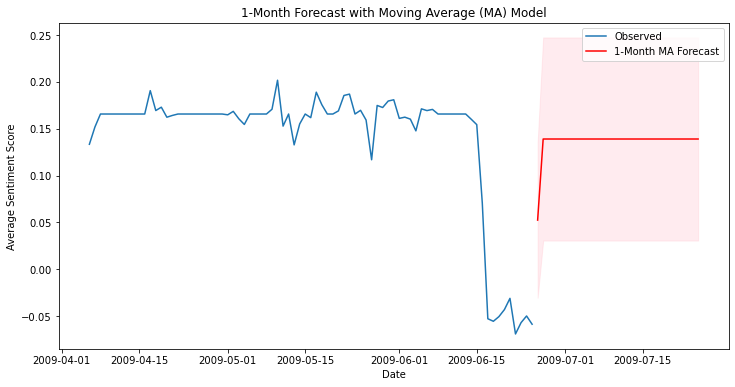

In [40]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Fit a Moving Average model (assuming MA(1) based on the initial ACF plot)
model = ARIMA(combined_sorted_pd['avg_score'], order=(0, 0, 1))  # MA(1) model
model_fit = model.fit()

# Forecast for the next 30 days (approximately 1 month)
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=combined_sorted_pd.index[-1], periods=31, closed='right')
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the observed data and the forecast with confidence intervals
plt.figure(figsize=(12,6))
plt.plot(combined_sorted_pd.index, combined_sorted_pd['avg_score'], label='Observed')
plt.plot(forecast_index, predicted_mean, color='red', label='1-Month MA Forecast')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('1-Month Forecast with Moving Average (MA) Model')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipykernel_28955/1274525750.py:11: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_index

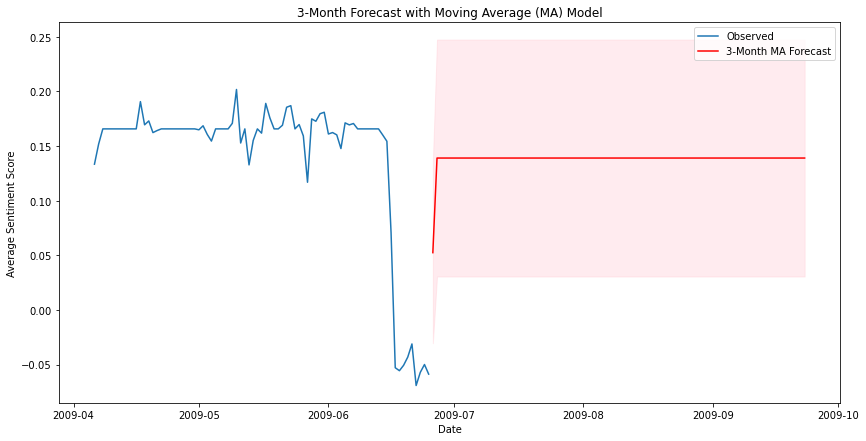

In [41]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Fit a Moving Average model (MA(1))
model = ARIMA(combined_sorted_pd['avg_score'], order=(0, 0, 1))
model_fit = model.fit()

# Forecast for the next 90 days (approximately 3 months)
forecast = model_fit.get_forecast(steps=90)
forecast_index = pd.date_range(start=combined_sorted_pd.index[-1], periods=91, closed='right')
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the observed data and the forecast with confidence intervals
plt.figure(figsize=(14,7))
plt.plot(combined_sorted_pd.index, combined_sorted_pd['avg_score'], label='Observed')
plt.plot(forecast_index, predicted_mean, color='red', label='3-Month MA Forecast')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('3-Month Forecast with Moving Average (MA) Model')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/tmp/ipykernel_28955/50144213.py:15: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



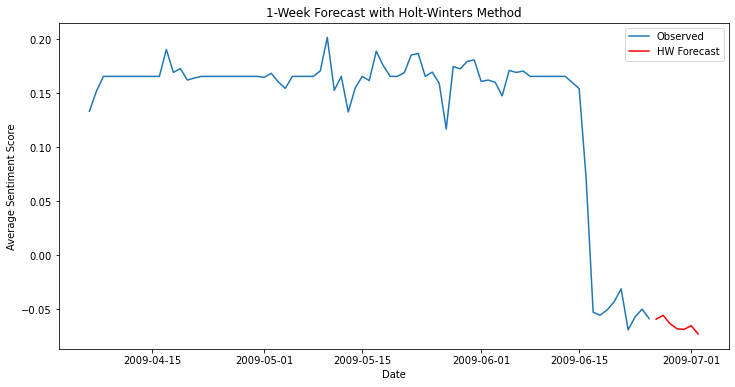

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/tmp/ipykernel_28955/3401427423.py:35: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provi

In [62]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters model
hw_model = ExponentialSmoothing(combined_sorted_pd['avg_score'],
                                trend='add',
                                seasonal='add',
                                seasonal_periods=4).fit() 

# 1 week forecast
hw_forecast = hw_model.forecast(7)

# PLot graph
plt.figure(figsize=(12,6))
plt.plot(combined_sorted_pd.index, combined_sorted_pd['avg_score'], label='Observed')
plt.plot(pd.date_range(start=combined_sorted_pd.index[-1], periods=8, closed='right'), hw_forecast, label='HW Forecast', color='red')
plt.title('1-Week Forecast with Holt-Winters Method')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_28955/2304017799.py:17: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=combined_sorted_pd.index[-1], periods=31, closed='right')


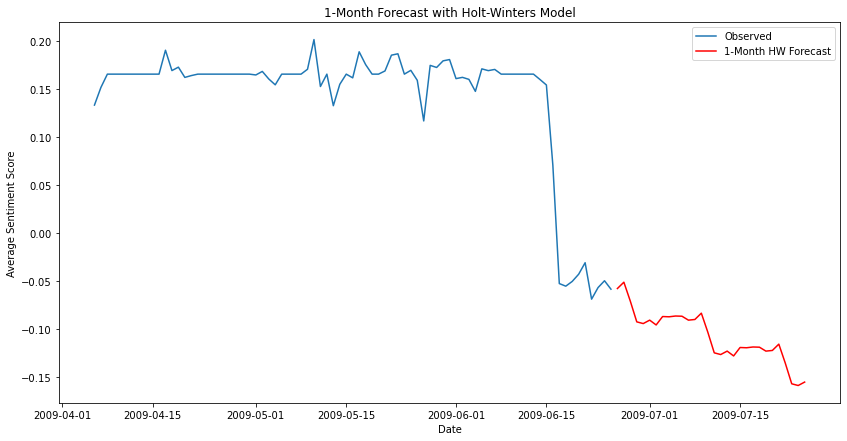

In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd

# Apply Holt-Winters model with both trend and seasonality components
hw_model = ExponentialSmoothing(
    combined_sorted_pd['avg_score'],
    trend='add',  # Additive trend
    seasonal='add',  # Additive seasonal component
    seasonal_periods=12,  # Assuming monthly data with yearly seasonality
    initialization_method="estimated"
).fit()

# Forecast for the next 30 days (approximately 1 month)
hw_forecast = hw_model.forecast(30)

forecast_dates = pd.date_range(start=combined_sorted_pd.index[-1], periods=31, closed='right')

# Plot the observed data and the forecast
plt.figure(figsize=(14,7))
plt.plot(combined_sorted_pd.index, combined_sorted_pd['avg_score'], label='Observed')
plt.plot(forecast_dates, hw_forecast, label='1-Month HW Forecast', color='red')
plt.title('1-Month Forecast with Holt-Winters Model')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_28955/250808168.py:17: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=combined_sorted_pd.index[-1], periods=91, closed='right')


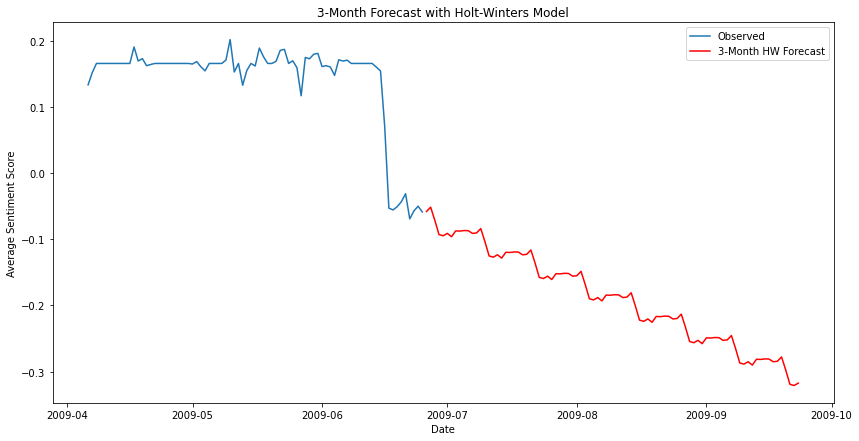

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd

# Apply Holt-Winters model with trend and seasonality components
hw_model = ExponentialSmoothing(
    combined_sorted_pd['avg_score'],
    trend='add',  # Additive trend
    seasonal='add',  # Additive seasonal component
    seasonal_periods=12,  # Assuming monthly data with yearly seasonality
    initialization_method="estimated"
).fit()

# Forecast for the next 90 days (approximately 3 months)
hw_forecast = hw_model.forecast(90)

forecast_dates = pd.date_range(start=combined_sorted_pd.index[-1], periods=91, closed='right')

# Plot the observed data and the forecast
plt.figure(figsize=(14,7))
plt.plot(combined_sorted_pd.index, combined_sorted_pd['avg_score'], label='Observed')
plt.plot(forecast_dates, hw_forecast, label='3-Month HW Forecast', color='red')
plt.title('3-Month Forecast with Holt-Winters Model')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

**SARIMA MODEL FORECASTING DASHBOARD**

In [48]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

_name_ = '_main_'

# Create a Dash application
app = dash.Dash(_name_)

app.layout = html.Div([
    dcc.Graph(id='time-series-plot'),
    html.P("Forecast length in days:"),
    dcc.Slider(
        id='forecast-slider',
        min=7, max=90, value=30,  # Adjusted for 1-week to 3-month forecast
        marks={i: '{} days'.format(i) for i in range(7, 91, 7)},
        step=7
    ),
])

@app.callback(
    Output('time-series-plot', 'figure'),
    [Input('forecast-slider', 'value')]
)
def update_graph(forecast_days):
    # Fit a SARIMA model
    model = SARIMAX(combined_sorted_pd['avg_score'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    
    # Forecast for the specified number of days
    forecast = model_fit.get_forecast(steps=forecast_days)
    forecast_index = pd.date_range(start=combined_sorted_pd.index[-1], periods=forecast_days+1, closed='right')
    predicted_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Create the figure
    fig = go.Figure([
        go.Scatter(x=combined_sorted_pd.index, y=combined_sorted_pd['avg_score'], name='Observed'),
        go.Scatter(x=forecast_index, y=predicted_mean, name='Forecast'),
        go.Scatter(
            x=forecast_index.tolist() + forecast_index[::-1].tolist(),
            y=conf_int.iloc[:, 0].tolist() + conf_int.iloc[:, 1][::-1].tolist(),
            fill='toself', fillcolor='rgba(231,107,243,0.2)',
            line=dict(color='rgba(231,107,243,0)'),
            hoverinfo="skip", showlegend=False, name='Confidence Interval'
        )
    ])
    fig.update_layout(title='Dynamic Forecast with SARIMA Model', xaxis_title='Date', yaxis_title='Average Sentiment Score')
    return fig

if _name_ == '_main_':
    app.run_server(debug=True)

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/tmp/ipykernel_28955/3401427423.py:35: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provi

**MONGODB AND MYSQL PERFORMANCE COMPARISON**

In [49]:
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("MongoDB Integration") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

# Read CSV file with Spark DataFrame
df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)

In [50]:
from pyspark.sql import SparkSession
my_spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.read.connection.uri", "mongodb://127.0.0.1/test.coll") \
    .config("spark.mongodb.write.connection.uri", "mongodb://127.0.0.1/test.coll") \
    .getOrCreate()

In [52]:
!--packages org.mongodb.spark:mongo-spark-connector_2.12:3.0.1

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--pretty-print
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [56]:
df.write.format("mongo") \
    .option("uri","mongodb://127.0.0.1:27017/") \
    .option("database","dbase") \
    .option("collection","clctn") \
    .mode("append") \
    .save()

Py4JJavaError: An error occurred while calling o411.save.
: java.lang.ClassNotFoundException: Failed to find data source: mongo. Please find packages at http://spark.apache.org/third-party-projects.html
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:692)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:746)
	at org.apache.spark.sql.DataFrameWriter.lookupV2Provider(DataFrameWriter.scala:993)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:311)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:301)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassNotFoundException: mongo.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:666)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:666)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:666)
	... 15 more


In [57]:
df.write.format("mongodb") \
        .option("uri","mongodb://127.0.0.1:27017/") \
        .option("database","dbase") \
        .option("collection","clctn") \
        .mode("append").save()

Py4JJavaError: An error occurred while calling o419.save.
: java.lang.ClassNotFoundException: Failed to find data source: mongodb. Please find packages at http://spark.apache.org/third-party-projects.html
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:692)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:746)
	at org.apache.spark.sql.DataFrameWriter.lookupV2Provider(DataFrameWriter.scala:993)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:311)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:301)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassNotFoundException: mongodb.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:666)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:666)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:666)
	... 15 more


In [58]:
mysql_options = {
    "url": "jdbc:mysql://localhost:3306/enestweet",  
    "driver": "com.mysql.cj.jdbc.Driver",  
    "dbtable": "enestweet_table",  
    "user": "root",  
    "password": "password" 
}

# Load DataFrame into MySQL database
df.write.format("jdbc").options(**mysql_options).mode("overwrite").save()

Py4JJavaError: An error occurred while calling o429.save.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:102)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:102)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:102)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:217)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:221)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:45)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:46)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:70)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:68)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:90)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:301)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


In [59]:
mysql_options = {
    "url": "jdbc:mysql://localhost:3306/enes_tweet",  
    "driver": "com.mysql.cj.jdbc.Driver",  
    "dbtable": "enes_tweet_table,  
    "user": "root",  
    "password": "password"  
}

# Load DataFrame into MySQL database
df.write.format("jdbc").options(**mysql_options).mode("overwrite").save()

SyntaxError: unterminated string literal (detected at line 4) (3479321479.py, line 4)

In [60]:
df = spark.read.jdbc(url="jdbc:mysql://localhost:3306/enes_tweet", table="enes_tweet_table", properties=mysql_options)

Py4JJavaError: An error occurred while calling o431.jdbc.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:102)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:102)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:102)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:38)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:32)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:355)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:325)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$3(DataFrameReader.scala:307)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:307)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:225)
	at org.apache.spark.sql.DataFrameReader.jdbc(DataFrameReader.scala:340)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


In [61]:
!/home/hduser/ycsb-0.17.0/bin/ycsb.sh run jdbc -P /home/hduser/ycsb-0.17.0/workloads/workloada -p db.url=jdbc:mysql://localhost:3306/tweet_mysql -p db.user=root -p db.passwd=password -p db.driver=com.mysql.cj.jdbc.Driver

/usr/bin/java  -classpath /home/hduser/ycsb-0.17.0/conf:/home/hduser/ycsb-0.17.0/lib/HdrHistogram-2.1.4.jar:/home/hduser/ycsb-0.17.0/lib/core-0.17.0.jar:/home/hduser/ycsb-0.17.0/lib/htrace-core4-4.1.0-incubating.jar:/home/hduser/ycsb-0.17.0/lib/jackson-core-asl-1.9.4.jar:/home/hduser/ycsb-0.17.0/lib/jackson-mapper-asl-1.9.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/conf:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-collections-3.2.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-lang-2.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-pool-1.5.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/geronimo-jms_1.1_spec-1.1.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/geronimo-jta_1.1_spec-1.1.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/jdbc-binding-0.17.0.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/mysql-connector-j-8.0.33.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/mysql-connector-java-8.0.30.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/openjpa-jdbc-2.1.1.jar:/ho